# Determine tanker transfer statistics
- Validate cargo capacities by investigating AIS data and the DOE transfers for vessels recorded by AIS. 
- This notebook is modified from `https://github.com/MIDOSS/analysis-rachael/blob/main/notebooks/monte_carlo_QAQC/QAQC_Tanker_AISlengths_DOEcapacities.ipynb` to focus on ECY transfers

---
Use `analysis-rachael/env/monte_carlo.yaml` to create an environment for this notebook:
```
 conda env create -f [analysis-rachael/env/monte_carlo.yaml]
```
or, to activate this environment, use
```
 conda activate monte-carlo
```
To deactivate an active environment, use
```
 conda deactivate
```
---  

In [1]:
# import necessary packages
import os
import yaml
import pandas
import numpy
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
import geopandas as gpd
from pathlib import Path
# import function for querying DOE dataframes
from dask import delayed
from monte_carlo_utils import get_DOE_df, get_bin

# set file location and name
doe_xls_path = Path(
    '/data/MIDOSS/spreadsheets/MuellerTrans4-30-20.xlsx'
)
fac_xls_path = Path(
    '/data/MIDOSS/marine_transport_data/Oil_Transfer_Facilities.xlsx'
)
yaml_out_dir = Path(
    '/data/MIDOSS/marine_transport_data/'
)

# import facility locations
facWA = pandas.read_excel(
    fac_xls_path,
    sheet_name = 'Washington',
    usecols="B,D,J,K"
)

# import facility locations
facCAD = pandas.read_excel(
    fac_xls_path,
    sheet_name = 'British Columbia',
    usecols="A",
    nrows=10
)

mpl.rc('font', size=11)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

# Import Dept. of Ecology transfer data
DOEdf = get_DOE_df(
    doe_xls_path, 
    fac_xls_path,
    group = 'no'
)

# Create list of names for tanker size classes evaluated
size_classes = [
    "Smallest Tanker (< 60 m)",
    "Small Tanker (61 - 150 m)", 
    "Handymax (151-200 m)", 
    "Aframax (201-250 m)", 
    "Suezmax (251-300 m)" 
]

#### Conversion factors

In [2]:
gal2liter = 3.78541

#### Initalizate dictionaries

In [3]:
# All AIS ship track data sorted by vessel type. 
allTracks={} 
# MMSI numbers and names by tanker size classes
mmsi_names = {}
# Number of MMSI used in each size class to evaluate cargo capacity using the DOE database
N_MMSI={}
# Percent of vessels in size class used in DOE evaluation
percent_total={}
# Tanker volume transfers
volume={}
imports={}
exports={}
one_way = {}
two_way = {}
# Probability of full tanker for hanymax (full, half-full, total)
handyVoyages={}
# Handymax oil cargo capacities and probability of full cargo
capacity = {}

In [4]:
fac_xls_path = Path(
    '/data/MIDOSS/marine_transport_data/Oil_Transfer_Facilities.xlsx'
)
fac_xls_path

PosixPath('/data/MIDOSS/marine_transport_data/Oil_Transfer_Facilities.xlsx')

In [5]:
def concat_shp(ship_type):
    """
      INPUT: 
          - ship_type ["tanker", "barge", "atb", etc]: MIDOSS-name for ship type (see oil_attribution.yaml for list)
      OUTPUT: 
          - dataframe of all 2018 ship tracks for given ship_type
      requirements: 
          This script requires being run on Salish.eoas.ubc.ca, with path to shapefiles being /data/MIDOSS/shapefiles/
    """
    for months in range(1,13):
        # set file location and name
        shp_path = Path(f'/data/MIDOSS/shapefiles/{ship_type}_2018_{months:02d}.shp')
        # import shapefile using geopandas
        monthly_shp = gpd.read_file(shp_path)
        if months == 1:
            print(f'creating {ship_type} shapefile for 2018, starting with January data')
            allTracks = monthly_shp
        else:
            print(f'Concatenating {ship_type} data from month {months}')
            allTracks = gpd.GeoDataFrame(
                pandas.concat([allTracks, monthly_shp])
            )
    return allTracks

In [6]:
def get_doe_tanker_byvessel(vessels,doe_xls_path,fac_xls_path):
    """
        Inputs:
            - vessels [list]: List of vessel names, e.g.["AMERICAN FREEDOM","PELICAN STATE"]
            - doe_xls_path [path]: Location and name of DOE data spreadsheet
            - fac_xls_path [path]: Location and name of facilities transfer spreadsheet
        Outputs:
            - cargo_transfers [dataframe]: 2018 cargo transfers to/from the vessels and 
               the marine terminals used in this study, in liters.  Transfers are grouped by AntID
    """
    # conversion factor
    gal2liter = 3.78541
    # load dept. of ecology data
    DOEdf = get_DOE_df(
        doe_xls_path, 
        fac_xls_path,
        group = 'no'
    )
    # extract tanker cargo transfers
    if isinstance(vessels, list):
        cargo_transfers = DOEdf.loc[
            (DOEdf.TransferType == 'Cargo') &
            (DOEdf.Deliverer.isin(vessels) |
             DOEdf.Receiver.isin(vessels)),
            ['TransferQtyInGallon', 'Deliverer','Receiver','StartDateTime','AntID']
        ].groupby('AntID').agg(
            {'TransferQtyInGallon':'sum',
             'Deliverer':'first', 
             'Receiver':'first',
             'StartDateTime':'first'}
            ).sort_values(by='TransferQtyInGallon',ascending=False)
    else: # if a string
         cargo_transfers = DOEdf.loc[
            (DOEdf.TransferType == 'Cargo') &
            (DOEdf.Deliverer.str.contains(vessels) |
             DOEdf.Receiver.str.contains(vessels)),
            ['TransferQtyInGallon', 'Deliverer','Receiver','StartDateTime','AntID']
        ].groupby('AntID').agg(
            {'TransferQtyInGallon':'sum',
             'Deliverer':'first', 
             'Receiver':'first',
             'StartDateTime':'first'}
            ).sort_values(by='TransferQtyInGallon',ascending=False)
    # convert to liters
    cargo_transfers['TransferQtyInGallon'] = gal2liter*cargo_transfers['TransferQtyInGallon']
    cargo_transfers=cargo_transfers.rename(
        columns={"TransferQtyInGallon":"TransferQtyInLiters"}
    ).reset_index()

    return cargo_transfers


In [7]:
def get_doe_byVesselType(type_description,doe_xls_path,fac_xls_path):
    """
        Inputs:
            - type_description [list]: List of vessel type, e.g.['TANK SHIP']
            - doe_xls_path [path]: Location and name of DOE data spreadsheet
            - fac_xls_path [path]: Location and name of facilities transfer spreadsheet
        Outputs:
            - cargo_transfers [dataframe]: 2018 cargo transfers to/from the vessels and 
               the marine terminals used in this study, in liters.  Transfers are grouped by AntID
    """
    # conversion factor
    gal2liter = 3.78541
    # load dept. of ecology data
    DOEdf = get_DOE_df(
        doe_xls_path, 
        fac_xls_path,
        group = 'no'
    )
    # extract tanker cargo transfers
    cargo_transfers = DOEdf.loc[
        (DOEdf.TransferType == 'Cargo') &
        (DOEdf.DelivererTypeDescription.isin(type_description) |
         DOEdf.ReceiverTypeDescription.isin(type_description)),
        ['TransferQtyInGallon', 'StartDateTime','AntID']
    ].groupby('AntID').agg(
        {'TransferQtyInGallon':'sum','StartDateTime':'first'}
        ).sort_values(by='TransferQtyInGallon',ascending=False)

    cargo_transfers['TransferQtyInGallon'] = gal2liter*cargo_transfers['TransferQtyInGallon']
    cargo_transfers=cargo_transfers.rename(
        columns={"TransferQtyInGallon":"TransferQtyInLiters"}
    ).reset_index()
    return cargo_transfers

In [8]:
def bins_labels(bins, **kwargs):
    """
    Labels x-axis of histogram with labels in center of bar
    Inputs:
        - bins [vector]: e.g. bins = numpy.arange(0,1.7e8,1e7)
    """
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(numpy.arange(min(bins)+bin_w/2, max(bins)+2*bin_w/2, bin_w), bins, **kwargs, rotation=90)
    plt.xlim(bins[0], bins[-1])
    

In [9]:
def split_doe_transfers(doe_df):
    """
    split dataframe of DOE transfers into two-way transfers (import and export) and one-way transfers
    """
    one_way=pandas.DataFrame({})
    two_way=pandas.DataFrame({})
    count = 0
    idx_taken = 0
    # order transfers by time
    doe_df = doe_df.sort_values(by='StartDateTime').reset_index(drop=True)
    # categorize transfers
    for idx,deliverer in enumerate(doe_df['Deliverer']):
        if idx != doe_df['Deliverer'].shape[0]-1:
            if ((doe_df['Deliverer'][idx] == doe_df['Receiver'][idx+1]) &
                (doe_df['Deliverer'][idx+1] == doe_df['Receiver'][idx])):
                # count number of cases where there is a delivery both ways
                count += 1
                two_way = two_way.append(doe_df.iloc[[idx]])
                idx_taken = 1
            else:
                if idx_taken:
                    two_way = two_way.append(doe_df.iloc[[idx]])
                    idx_taken = 0
                else:
                    one_way = one_way.append(doe_df.iloc[[idx]])
                    idx_taken = 0
        else:
            # categorize the last entry by comparing with the end - 1 values
            if ((doe_df['Deliverer'][idx] == doe_df['Receiver'][idx-1]) &
                (doe_df['Deliverer'][idx-1] == doe_df['Receiver'][idx])):
                count += 1
                two_way = two_way.append(doe_df.iloc[[idx]])
    return one_way, two_way

### Concat 2018 tanker traffic AIS

In [10]:
%%time
ship_type = "tanker"
allTracks["tanker"] = concat_shp("tanker")

creating tanker shapefile for 2018, starting with January data
Concatenating tanker data from month 2
Concatenating tanker data from month 3
Concatenating tanker data from month 4
Concatenating tanker data from month 5
Concatenating tanker data from month 6
Concatenating tanker data from month 7
Concatenating tanker data from month 8
Concatenating tanker data from month 9
Concatenating tanker data from month 10
Concatenating tanker data from month 11
Concatenating tanker data from month 12
CPU times: user 1min 11s, sys: 1.42 s, total: 1min 12s
Wall time: 1min 12s


In [11]:
# This is needed for later one, when I use enumerate(allTracks["tanker"]["LENGTH"])
# to bin MMSI and vessel lengths according to our criteria for different tanker lengths
allTracks["tanker"] = allTracks["tanker"].reset_index(drop=True)

In [12]:
#median length for "small" tanker class
sm_tankers = allTracks["tanker"].loc[
    (allTracks["tanker"]["LENGTH"]>60) & 
    (allTracks["tanker"]["LENGTH"]<155),
    ['LENGTH','MMSI_NUM']
]
numpy.median(sm_tankers['LENGTH'])

144.0

Text(0.5, 1.0, 'Ship track count for tankers < 155 m')

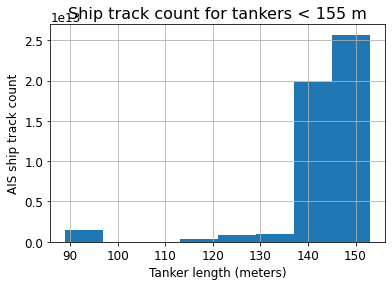

In [13]:
hist=sm_tankers.LENGTH.hist(weights=sm_tankers.MMSI_NUM, bins=8)
hist.set_ylabel('AIS ship track count')
hist.set_xlabel('Tanker length (meters)')
hist.set_title('Ship track count for tankers < 155 m')

#### create histogram for all tanker lenghts and mmsi

Text(0.5, 1.0, 'Ship track count for all tankers')

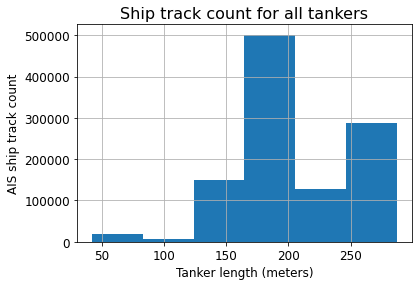

In [14]:
all_tankers = allTracks["tanker"][['LENGTH','MMSI_NUM']].groupby('LENGTH').count().sort_values(by='MMSI_NUM',ascending=False).reset_index()
hist=all_tankers.LENGTH.hist(weights=all_tankers.MMSI_NUM, bins=6)
hist.set_ylabel('AIS ship track count')
hist.set_xlabel('Tanker length (meters)')
hist.set_title('Ship track count for all tankers')

In [15]:
### The top three receivers of DOE transfers are for KIRKEHOLMEN, OVERSEAS LOS ANGELES, and PELICAN STATE

## Create histogram of tanker lengths

In [16]:
bins = []
bins.append((0, 60))
bins.append((61, 150))
bins.append((151, 200))
bins.append((201, 250))
bins.append((251, 300))

binned_data = numpy.zeros(len(bins))
binned_mmsi = pandas.DataFrame(columns = size_classes)
for idx,value in enumerate(allTracks["tanker"]["LENGTH"]):
    if value > 0:
        bin_index = get_bin(value, bins)  
        binned_data[bin_index] += 1    

0 19025.0
1 84730.0
2 572427.0
3 142846.0
4 272345.0


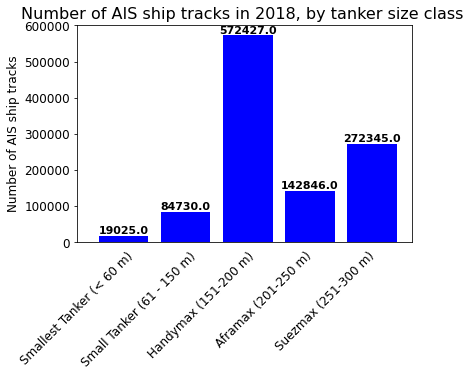

In [17]:
fig, ax = plt.subplots()    
#width = 0.75 # the width of the bars 
ind = numpy.arange(len(binned_data))  # the x locations for the groups
ax.bar(ind, binned_data, color="blue")
ax.set_xticks(ind-3/4)
ax.set_xticklabels(size_classes, minor=False, rotation=45)
ax.tick_params(axis = "x", which = "both", bottom = False, top = False)
plt.title('Number of AIS ship tracks in 2018, by tanker size class ')
#plt.xlabel('Tanker size class', rotation=45)
plt.ylabel('Number of AIS ship tracks')
for i, v in enumerate(binned_data):
    print(i,v)
    ax.text(i, v, str(v), color='black', fontweight='bold', ha='center', va='bottom')

In [18]:
size_classes

['Smallest Tanker (< 60 m)',
 'Small Tanker (61 - 150 m)',
 'Handymax (151-200 m)',
 'Aframax (201-250 m)',
 'Suezmax (251-300 m)']

In [19]:
binned_mmsi = {}
for idx,sizeclass in enumerate(size_classes):
    #print(idx,sizeclass)
    binned_mmsi[sizeclass]= allTracks["tanker"].loc[
        (allTracks["tanker"]["LENGTH"] > bins[idx][0]) & 
        (allTracks["tanker"]["LENGTH"] < bins[idx][1]),
        ['MMSI_NUM','LENGTH']
    ].groupby('MMSI_NUM').count().sort_values(by='LENGTH',ascending=False).rename(columns={'LENGTH':'COUNT'})

# Print the MMSI count per size class

In [20]:
for sizeclass in size_classes:
    print(f'** {binned_mmsi[sizeclass].shape[0]} ** {sizeclass} vessels')

** 1 ** Smallest Tanker (< 60 m) vessels
** 19 ** Small Tanker (61 - 150 m) vessels
** 140 ** Handymax (151-200 m) vessels
** 69 ** Aframax (201-250 m) vessels
** 29 ** Suezmax (251-300 m) vessels


## Link vessel names to MMSI with the most AIS ship tracks in 2018, by category
- Vessels ranked in and selected from `binned_mmsi`

In [21]:
mmsi_names["Smallest Tanker (< 60 m)"]= {
    368009250:"GLOBAL PROVIDER"
}
mmsi_names["Small Tanker (61 - 150 m)"] = {
    355320000:"KIRKEHOLMEN",
    566306000:"MTM HOUSTON",
    477636500:"BOCHEM LONDON"
}
mmsi_names["Handymax (151-200 m)"] = {
    369042000:"AMERICAN FREEDOM",
    367353110:"PELICAN STATE", 
    366855000:"FLORIDA", 
    367134000:"OVERSEAS LOS ANGELES",
    369040000:"AMERICAN ENDURANCE",
    356159000:"OPEC VICTORY",
    212656000:"PANAGIA THALASSINI",
    538006302:"SONGA PRIDE",
    538004682:"ZAO GALAXY",
    538007277:"CHEMBULK LINDY ALICE",
    538004167:"ARGENT IRIS",
    338221000:"OVERSEAS BOSTON",
    477185200:"RAINBOW STAR",
    538005425:"STI BATTERY",
    636017622:"HIGH CHALLENGE",
    538006892:"NAVIG8 SPARK",
    563054800:"NAEBA GALAXY",
    563046100:"HODAKA GALAXY",
    367353070:"EVERGREEN STATE",
    566150000:"MAERSK TIANJIN",
}
mmsi_names["Aframax (201-250 m)"] = {         
    636015178:"AQUALEGACY",
    220518000:"TORM EMILIE",
    255806154:"NORDTULIP",
    311943000:"GULF PEARL",
    538001893:"ELAN VITAL"
}
mmsi_names["Suezmax (251-300 m)"] = {
    303294000:"ALASKAN EXPLORER",
    367688000:"ALASKAN NAVIGATOR", 
    303656000:"ALASKA LEGEND", 
    366948190:"ALASKA FRONTIER"
}

## Print percent of total traffic represented given MMSI in size classes

In [22]:
# Count the number of MMSI used in each size class to evaluate cargo capacity using the DOE database
N_MMSI["Smallest"] = len(mmsi_names["Smallest Tanker (< 60 m)"])
N_MMSI["Small"] = len(mmsi_names["Small Tanker (61 - 150 m)"])
N_MMSI["Handymax"] = len(mmsi_names["Handymax (151-200 m)"])
N_MMSI["Aframax"] = len(mmsi_names["Aframax (201-250 m)"])
N_MMSI["Suezmax"] = len(mmsi_names["Suezmax (251-300 m)"])

In [23]:
# calculate percent total using the number of MMSI above
print('Percent of vessels in size class used in DOE evaluation')
for idx,label in enumerate([*N_MMSI]):
    percent_total[label]=sum(
    binned_mmsi[[*mmsi_names][idx]].COUNT.iloc[0:N_MMSI[label]])/\
    sum(binned_mmsi[[*mmsi_names][idx]].COUNT
    )
    print(f'* {100*percent_total[label]:.2f}% {label} ') 

Percent of vessels in size class used in DOE evaluation
* 100.00% Smallest 
* 54.55% Small 
* 58.15% Handymax 
* 17.99% Aframax 
* 50.80% Suezmax 


In [24]:
# Test how many Aframax we would need to get over 50%
sum(
    binned_mmsi["Aframax (201-250 m)"].COUNT.iloc[0:20])/\
    sum(binned_mmsi["Aframax (201-250 m)"].COUNT
   )

0.5104028114192907

#### NOTE: We would need to evaluation the 20 Aframax with most AIS ship tracks to get to 51% of vessel tracks

## Create a histogram of tanker volume transfers

In [25]:
vessel_type = 'tanker'
transfer_type = 'Cargo'
type_description = ['TANK SHIP']
volume[vessel_type] = get_doe_byVesselType(type_description,doe_xls_path,fac_xls_path)

In [26]:
print(max(volume[vessel_type]['TransferQtyInLiters']))

143337002.59568


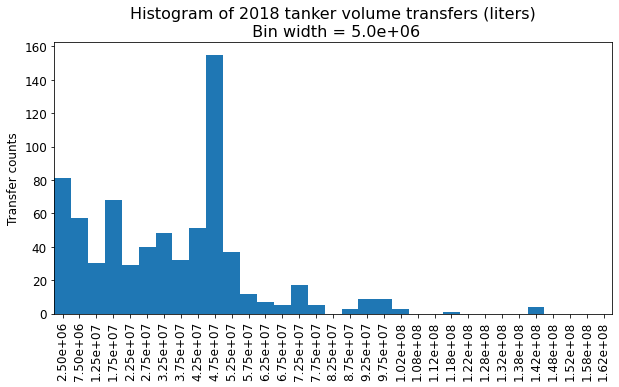

In [27]:
   
fig, ax = plt.subplots(figsize=(10, 5))
bin_width = 5e6
bins = numpy.arange(0,1.7e8,bin_width)
plt.hist(volume[vessel_type]['TransferQtyInLiters'], bins=bins)#, histtype = 'bar', facecolor = 'blue')
bins_labels(bins, fontsize=12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.ylabel("Transfer counts")
#plt.xlabel("Bin Number")
plt.title(f"Histogram of 2018 tanker volume transfers (liters)\n Bin width = {bin_width:1.1e}")
plt.show()

#### Thoughts:
- **Handymax** has the most number of ship tracks in 2018. The 4.5-5e7 liter size class is consistent with Handymax size.  
- The cargo capacities we are using based on SILO are: 
    - **smallest tanker** 5.8e5
    - **small tanker** 1.5e7
    - **handymax**	5.3e7
    - **aframax**	1.26e8
    - **suezmax**	1.85e8
- According to the [ATC](https://www.aktanker.com/fleet-main) website, **Alaskan Explorer's carrying capacity is 206,683,483.4 liters**.  This is true of all their tankers, three of which are the first three in AIS ship track counts in 2018.  
    - 366948190.0   5940
    - 303656000.0  24133
    - 303294000.0  29376
    - 367688000.0  25157
- **Suezmax**:The max transfer is 1.5e8 liters.  Max capacity is 2.1e8.  We classify max capacity of Suezmax as 1.85e8.  
- We use 5 values of oil cargo capacity for tankers based on their size class. The DOE transfers suggest the following max cargo capacities for these categories
    - **Smallest tanker**: 5.8e5 (based on max transfers for MMSI with most ship tracks, also, [Global Provider](https://www.professionalmariner.com/global-provider/) is given a cargo capacity of 567811.768)
    - **Small tanker**: 1.5e7 (based on max transfers for MMSI  with most ship tracks)
    - **Small tanker**: 1.75e7 (based on histogram)
    - **Handymax**: 4e7 (based on max transfers for the two MMSI with most ship tracks)
    - **Handymax**: 4.75e7 (based on histogram)
    - **Aframax**: 1.2e8 (based on histogram)
    - **Suezmax**: 1.5e8 (based on histogram, this is ~71% capacity)
- **Question**: Do we want to adjust any of the values that we are using?  The values I am considering changing are:
    
    -**Handymax** from 5.3e7 to 4.75e7 and 
    -**Suezmax** from 1.85e8 to 1.5e8. 

### Check Small tankers 

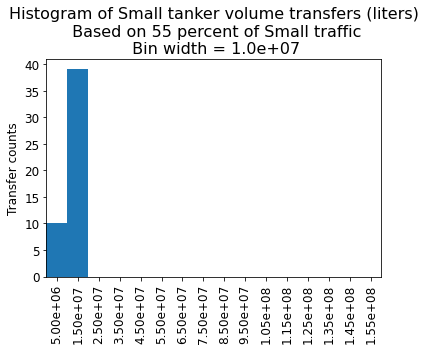

18283530.3

In [28]:
# Get transfers for these two examples of Handymax 
vessels = list(mmsi_names["Small Tanker (61 - 150 m)"].values())
vessel_type = 'Small'
volume[vessel_type] = get_doe_tanker_byvessel(vessels,doe_xls_path,fac_xls_path)

# plot histogram of handimax transfers
fig, ax = plt.subplots()
bin_width = 1e7
bins = numpy.arange(0,1.7e8,bin_width)
plt.hist(volume[vessel_type]['TransferQtyInLiters'], bins=bins)#, histtype = 'bar', facecolor = 'blue')
bins_labels(bins, fontsize=12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.ylabel("Transfer counts")
plt.title(f"Histogram of Small tanker volume transfers (liters)\n Based on {100*percent_total['Small']:.0f} percent of Small traffic\n Bin width = {bin_width:1.1e}")
plt.show()

max(volume[vessel_type]['TransferQtyInLiters'])

### Check Handymax tankers using transfers for the ten vessels with the most AIS ship tracks

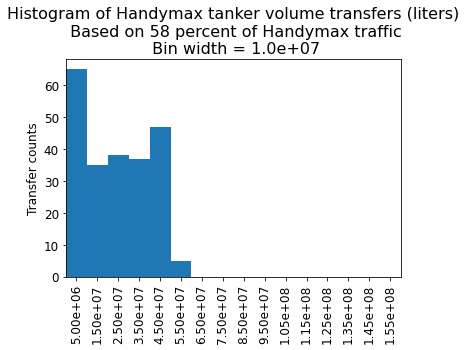

51034897.620000005

In [29]:
# Get transfers for these two examples of Handymax 
vessels = list(mmsi_names["Handymax (151-200 m)"].values())
vessel_type = 'Handymax'
volume[vessel_type] = get_doe_tanker_byvessel(vessels,doe_xls_path,fac_xls_path)

# plot histogram of handimax transfers
fig, ax = plt.subplots()
bin_width = 1e7
bins = numpy.arange(0,1.7e8,bin_width)
plt.hist(volume[vessel_type]['TransferQtyInLiters'], bins=bins)#, histtype = 'bar', facecolor = 'blue')
bins_labels(bins, fontsize=12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.ylabel("Transfer counts")
plt.title(f"Histogram of Handymax tanker volume transfers (liters)\n Based on {100*percent_total['Handymax']:.0f} percent of Handymax traffic\n Bin width = {bin_width:1.1e}")
plt.show()

max(volume['Handymax']['TransferQtyInLiters'])

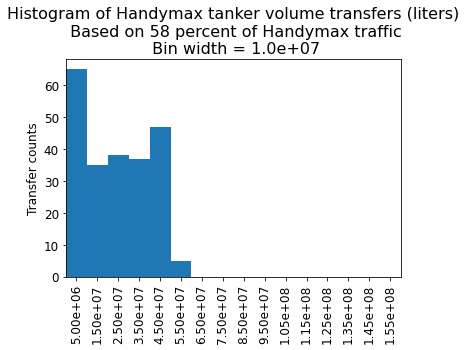

In [30]:
vessels = list(mmsi_names["Handymax (151-200 m)"].values())
vessel_type = 'Handymax'
volume[vessel_type] = get_doe_tanker_byvessel(vessels,doe_xls_path,fac_xls_path)
pandas.set_option('display.max_rows', volume[vessel_type].shape[0]+1)


# plot histogram of handimax transfers
fig, ax = plt.subplots()
bin_width = 1e7
bins = numpy.arange(0,1.7e8,bin_width)
plt.hist(volume[vessel_type]['TransferQtyInLiters'], bins=bins)#, histtype = 'bar', facecolor = 'blue')
bins_labels(bins, fontsize=12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.ylabel("Transfer counts")
plt.title(f"Histogram of Handymax tanker volume transfers (liters)\n Based on {100*percent_total['Handymax']:.0f} percent of Handymax traffic\n Bin width = {bin_width:1.1e}")
plt.show()



#### Divide transfers into those with both import and export vs. one-way only:
- 100% full tankers that have import and export transfers per terminal stop ("double" transfer) and 
- 50% tankers that have either import or export ("single" transfer) 

In [31]:
for idx,vessel_type in enumerate([*N_MMSI]):
    # get list of vessel names by size class
    vessels = list(mmsi_names[[*mmsi_names][idx]].values())
    volume[vessel_type] = get_doe_tanker_byvessel(
        vessels, doe_xls_path, fac_xls_path)
    volume[vessel_type] = volume[vessel_type].sort_values(by='StartDateTime').reset_index()

In [32]:
for idx,vessel_type in enumerate([*N_MMSI]):
    one_way[vessel_type], two_way[vessel_type]  = split_doe_transfers(
        volume[vessel_type])
    print(f'{vessel_type}: {one_way[vessel_type].shape[0]} one-way, {two_way[vessel_type].shape[0]} two-way transfers')

Smallest: 35 one-way, 2 two-way transfers
Small: 48 one-way, 0 two-way transfers
Handymax: 134 one-way, 93 two-way transfers
Aframax: 8 one-way, 2 two-way transfers
Suezmax: 39 one-way, 3 two-way transfers


### Calculate probability of full tanker for handimax

In [33]:
handyVoyages['full'] = two_way['Handymax'].shape[0]
handyVoyages['half_full'] = 2*one_way['Handymax'].shape[0]
handyVoyages['total'] = handyVoyages['full']+handyVoyages['half_full']
handyFullProbability = (1.0 * handyVoyages['full']/handyVoyages['total'] +
                        0.5 * handyVoyages['half_full']/handyVoyages['total'])
# Assign output to yaml file used in oil_attribution.ipynb
capacity['probability_full_handymax'] = handyFullProbability
print(f'Probability of full Handymax: {handyFullProbability:.2f}')

Probability of full Handymax: 0.63


#### List number of WA state DOE transfers per Handymax
- NOTE: Absent DOE transfers -> CAD traffic

In [34]:
total = 0
vessels = list(mmsi_names["Handymax (151-200 m)"].values())
for vessel in vessels:
    test = get_doe_tanker_byvessel(vessel,doe_xls_path,fac_xls_path)
    print(vessel, test.shape[0])
    total += test.shape[0]
total

AMERICAN FREEDOM 31
PELICAN STATE 34
FLORIDA 25
OVERSEAS LOS ANGELES 41
AMERICAN ENDURANCE 39
OPEC VICTORY 0
PANAGIA THALASSINI 1
SONGA PRIDE 1
ZAO GALAXY 0
CHEMBULK LINDY ALICE 1
ARGENT IRIS 0
OVERSEAS BOSTON 26
RAINBOW STAR 6
STI BATTERY 5
HIGH CHALLENGE 2
NAVIG8 SPARK 2
NAEBA GALAXY 0
HODAKA GALAXY 3
EVERGREEN STATE 9
MAERSK TIANJIN 1


227

#### NOTE: Some of the top tankers in AIS ship tracks are partially or fully CAD and not represented in the DOE transfers

In [35]:
vessel_type = 'Handymax'
volume[vessel_type]['Deliverer'].shape[0]

227

In [36]:
print(f'{two_way[vessel_type].shape[0]} paired transfers')
print(f'{one_way[vessel_type].shape[0]} single transfers')

93 paired transfers
134 single transfers


Text(0.5, 1.0, 'Handymax transfer quantities (liters) for vessels that are 50% full')

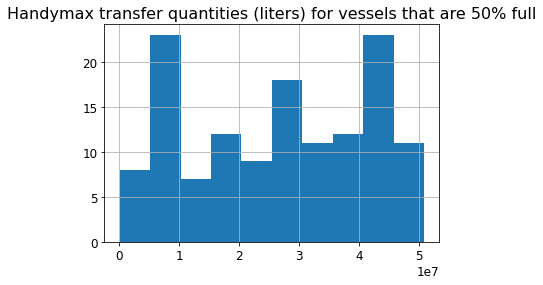

In [37]:
ax = one_way[vessel_type]['TransferQtyInLiters'].hist()
ax.set_title('Handymax transfer quantities (liters) for vessels that are 50% full')

Text(0.5, 1.0, 'Handymax transfer quantities (liters) for vessels that are 100% full')

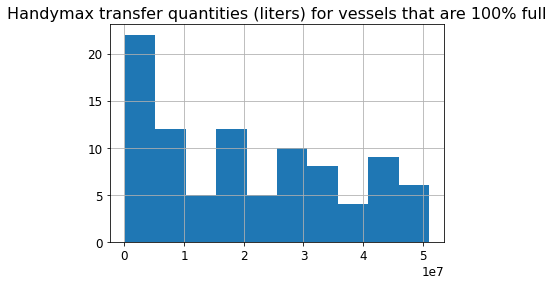

In [38]:
ax = two_way[vessel_type]['TransferQtyInLiters'].hist()
ax.set_title('Handymax transfer quantities (liters) for vessels that are 100% full')

Text(0.5, 1.0, 'Handymax transfer quantities (liters) for all vessels')

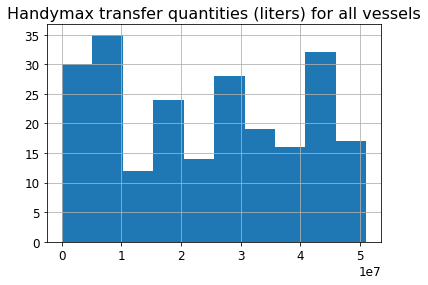

In [39]:
handimax_combined = one_way[vessel_type].append(two_way[vessel_type])
ax = handimax_combined['TransferQtyInLiters'].hist()
ax.set_title('Handymax transfer quantities (liters) for all vessels')

In [40]:
max(volume['Handymax']['TransferQtyInLiters'])

51034897.620000005

Text(0.5, 1.0, 'Handymax max cargo distribution')

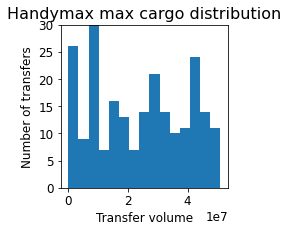

In [41]:
nbins = 15
max_full = max(volume['Handymax']['TransferQtyInLiters'])
# if max(volume['Handymax']['TransferQtyInLiters']) > max_full:
#     raise ValueError('Upper bin limit for Handymax needs to be ajusted up')

bin_values = numpy.arange(
    0,
    max_full + max_full/nbins,
    max_full/nbins
)

fig, ax = plt.subplots(figsize = (3,3))
n, cargo_capacity, patches = ax.hist(
        volume['Handymax']['TransferQtyInLiters'],
        bins = bin_values)
ax.set_xlabel('Transfer volume')
ax.set_ylabel('Number of transfers')
ax.set_ylim(0,30)
ax.set_title(f'Handymax max cargo distribution')

In [45]:
print(f'Max Handymax volume transfer (liters): {max(volume["Handymax"]["TransferQtyInLiters"])}')

Max Handymax volume transfer (liters): 51034897.620000005


In [46]:
weights = n/sum(n)
capacity['weights'] = weights.tolist()
#cargo_capacity['amount_in_liters'].pop(0) # Remove zero (lower bound of first bin)
capacity['amount_in_liters'] = cargo_capacity.tolist()
capacity['amount_in_liters'].pop(0)
print(f'{len(capacity["amount_in_liters"])} =? {len(capacity["weights"])}')
capacity

15 =? 15


{'probability_full_handymax': 0.628808864265928,
 'weights': [0.1145374449339207,
  0.039647577092511016,
  0.13215859030837004,
  0.030837004405286344,
  0.07048458149779736,
  0.05726872246696035,
  0.030837004405286344,
  0.06167400881057269,
  0.09251101321585903,
  0.06167400881057269,
  0.04405286343612335,
  0.048458149779735685,
  0.10572687224669604,
  0.06167400881057269,
  0.048458149779735685],
 'amount_in_liters': [3402326.5080000004,
  6804653.016000001,
  10206979.524,
  13609306.032000002,
  17011632.540000003,
  20413959.048,
  23816285.556,
  27218612.064000003,
  30620938.572000004,
  34023265.080000006,
  37425591.58800001,
  40827918.096,
  44230244.604,
  47632571.112,
  51034897.620000005]}

In [47]:
with open(yaml_out_dir/'handymax_capacity.yaml', 'w') as file:
    documents = yaml.safe_dump(capacity, file)

### Show histograms of Aframax transfers 

In [48]:
binned_mmsi["Aframax (201-250 m)"].iloc[:5]

,COUNT
MMSI_NUM,
636015178.0,6057
220518000.0,5718
255806154.0,5140
311943000.0,4609
538001893.0,4172


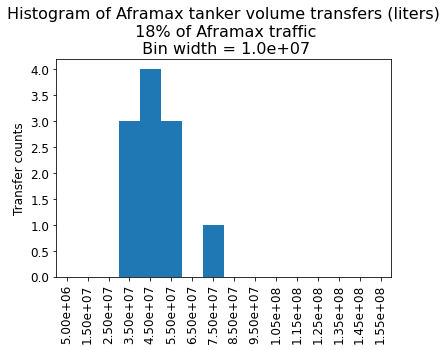

79493610.0

In [49]:
vessels = list(mmsi_names["Aframax (201-250 m)"].values()) 
vessel_type = 'Aframax'
volume[vessel_type] = get_doe_tanker_byvessel(vessels,doe_xls_path,fac_xls_path)

# plot histogram of handimax transfers
fig, ax = plt.subplots()
bin_width = 1e7
bins = numpy.arange(0,1.7e8,bin_width)
plt.hist(volume[vessel_type]['TransferQtyInLiters'], bins=bins)#, histtype = 'bar', facecolor = 'blue')
bins_labels(bins, fontsize=12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.ylabel("Transfer counts")
plt.title(f"Histogram of Aframax tanker volume transfers (liters)\n {100*percent_total['Aframax']:.0f}% of Aframax traffic\n Bin width = {bin_width:1.1e}")
plt.show()

max(volume['Aframax']['TransferQtyInLiters'])

### Take away:  In some cases, multiple AntIDs are used to represent cargo transfers for a given voyage.  The sum of these is close to 1e8, which approximates SILO value of 1.26e8

### Show histograms of Suezmax transfers 

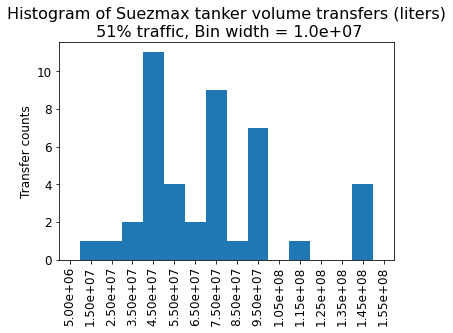

143337002.59568

In [50]:
vessels = ['ALASKAN EXPLORER', "ALASKAN NAVIGATOR", "ALASKA LEGEND", "ALASKA FRONTIER"] 
vessel_type = 'Suezmax'
volume[vessel_type] = get_doe_tanker_byvessel(vessels,doe_xls_path,fac_xls_path)

fig, ax = plt.subplots()
bin_width = 1e7
bins = numpy.arange(0,1.7e8,bin_width)
plt.hist(volume[vessel_type]['TransferQtyInLiters'], bins=bins)#, histtype = 'bar', facecolor = 'blue')
bins_labels(bins, fontsize=12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.ylabel("Transfer counts")
plt.title(f"Histogram of Suezmax tanker volume transfers (liters)\n {100*percent_total['Suezmax']:.0f}% traffic, Bin width = {bin_width:1.1e}")
plt.show()

max(volume['Suezmax']['TransferQtyInLiters'])

# Cargo transfer evaluations 

### Handymax

In [51]:
vessels = ["AMERICAN FREEDOM","PELICAN STATE", "FLORIDA",
          'PANAGIA THALASSINI','CHEMBULK LINDY ALICE','ZAO GALAXY',
           'OVERSEAS LOS ANGELES','AMERICAN ENDURANCE','OPEC VICTORY','SONGA PRIDE',] 
vessel_type = 'Handymax'

### Get a sense of behavior with fueling
volume[vessel_type] = DOEdf.loc[
    (DOEdf.Deliverer.isin(vessels) |
     DOEdf.Receiver.isin(vessels)),
    ['TransferQtyInGallon', 'Deliverer','Receiver','StartDateTime','AntID']
].groupby('AntID').agg(
    {'TransferQtyInGallon':'sum','Deliverer':'first', 'Receiver':'first','StartDateTime':'first'}
    ).sort_values(by='TransferQtyInGallon',ascending=False)

volume[vessel_type]['TransferQtyInLiters'] = gal2liter*volume[vessel_type]['TransferQtyInGallon']
volume[vessel_type]=volume[vessel_type].sort_values(by='StartDateTime')
pandas.set_option('display.max_rows', volume[vessel_type].shape[0]+1)
volume[vessel_type]

,TransferQtyInGallon,Deliverer,Receiver,StartDateTime,TransferQtyInLiters
AntID,,,,,
173668,12096000.0,BP Cherry Point Refinery,PELICAN STATE,2018-01-07 16:30:00,4.578832e+07
173766,11256000.0,BP Cherry Point Refinery,OVERSEAS LOS ANGELES,2018-01-09 00:01:00,4.260857e+07
173900,2289000.0,OVERSEAS LOS ANGELES,BP Cherry Point Refinery,2018-01-09 05:00:00,8.664803e+06
174271,206684.0,HMS 26-1,PELICAN STATE,2018-01-22 07:00:00,7.823837e+05
174103,11340000.0,BP Cherry Point Refinery,PELICAN STATE,2018-01-22 15:00:00,4.292655e+07
174265,4620000.0,Marathon Anacortes Refinery (formerly Tesoro),AMERICAN ENDURANCE,2018-01-22 19:30:00,1.748859e+07
174264,7560000.0,AMERICAN ENDURANCE,Marathon Anacortes Refinery (formerly Tesoro),2018-01-22 19:30:00,2.861770e+07
174281,287061.0,HMS 2000,AMERICAN FREEDOM,2018-01-23 11:00:00,1.086644e+06
174153,3280700.0,CHEMBULK LINDY ALICE,"REG Grays Harbor, LLC",2018-01-24 14:00:00,1.241879e+07


### Aframax

In [52]:
### Get a sense of behavior with fueling
volume['Aframax'] = DOEdf.loc[
    (DOEdf.Deliverer.isin(["AQUALEGACY","TORM EMILIE","NORDTULIP","GULF PEARL","ELAN VITAL"] ) |
     DOEdf.Receiver.isin(["AQUALEGACY","TORM EMILIE","NORDTULIP","GULF PEARL","ELAN VITAL"] )),
    ['TransferQtyInGallon', 'Deliverer','Receiver','StartDateTime','AntID']
].groupby('AntID').agg(
    {'TransferQtyInGallon':'sum','Deliverer':'first', 'Receiver':'first','StartDateTime':'first'}
    ).sort_values(by='TransferQtyInGallon',ascending=False)

volume['Aframax']['TransferQtyInLiters'] = gal2liter*volume['Aframax']['TransferQtyInGallon']
volume['Aframax']=volume['Aframax'].sort_values(by='StartDateTime')
pandas.set_option('display.max_rows', volume['Aframax'].shape[0]+1)
volume['Aframax']

,TransferQtyInGallon,Deliverer,Receiver,StartDateTime,TransferQtyInLiters
AntID,,,,,
173665,9408000.0,BP Cherry Point Refinery,TORM EMILIE,2018-01-06 07:00:00,3.561314e+07
173852,15582000.0,BP Cherry Point Refinery,TORM EMILIE,2018-01-13 09:00:00,5.898426e+07
175412,278859.0,HMS 2000,TORM EMILIE,2018-02-26 10:00:00,1.055596e+06
177564,196841.0,HMS 2000,TORM EMILIE,2018-05-02 19:00:00,7.451239e+05
177195,21000000.0,TORM EMILIE,BP Cherry Point Refinery,2018-05-07 09:00:00,7.949361e+07
179965,8400000.0,AQUALEGACY,Shell Puget Sound Refinery,2018-06-28 14:00:00,3.179744e+07
180176,8400000.0,AQUALEGACY,Shell Puget Sound Refinery,2018-07-01 12:00:00,3.179744e+07
180194,426490.0,HMS 2000,AQUALEGACY,2018-07-02 14:00:00,1.614440e+06
181416,11550000.0,NORDTULIP,BP Cherry Point Refinery,2018-08-02 14:00:00,4.372149e+07


### Suezmax

#### Take-away:  Indeed...big boats distribute in smaller transfers.  Show transfers to evaluate.

In [53]:
volume['Suezmax']=volume['Suezmax'].sort_values(by='StartDateTime')
pandas.set_option('display.max_rows', volume['Suezmax'].shape[0]+1)
volume['Suezmax']

,AntID,TransferQtyInLiters,Deliverer,Receiver,StartDateTime
38,173584,4.769617e+07,ALASKAN NAVIGATOR,Marathon Anacortes Refinery (formerly Tesoro),2018-01-02 12:00:00
18,173667,7.154425e+07,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-07 21:30:00
15,173850,7.297513e+07,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-12 14:00:00
40,174331,3.179744e+07,ALASKAN NAVIGATOR,BP Cherry Point Refinery,2018-01-24 00:01:00
10,174335,9.381343e+07,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-27 13:00:00
30,174495,4.769617e+07,ALASKAN EXPLORER,Shell Puget Sound Refinery,2018-01-30 12:00:00
5,174614,9.602828e+07,ALASKAN NAVIGATOR,BP Cherry Point Refinery,2018-02-04 09:30:00
31,174716,4.769617e+07,ALASKAN NAVIGATOR,Shell Puget Sound Refinery,2018-02-06 10:00:00
20,174923,7.154425e+07,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-02-16 08:00:00
21,175146,7.154425e+07,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-02-19 09:30:00


In [54]:
### Get a sense of behavior with fueling
volume['Suezmax'] = DOEdf.loc[
    (DOEdf.Deliverer.isin(['ALASKAN EXPLORER', "ALASKAN NAVIGATOR", "ALASKA LEGEND", "ALASKA FRONTIER"]) |
     DOEdf.Receiver.isin(['ALASKAN EXPLORER', "ALASKAN NAVIGATOR", "ALASKA LEGEND", "ALASKA FRONTIER"])),
    ['TransferQtyInGallon', 'Deliverer','Receiver','StartDateTime','AntID']
].groupby('AntID').agg(
    {'TransferQtyInGallon':'sum','Deliverer':'first', 'Receiver':'first','StartDateTime':'first'}
    ).sort_values(by='TransferQtyInGallon',ascending=False)

volume['Suezmax']['TransferQtyInLiters'] = gal2liter*volume['Suezmax']['TransferQtyInGallon']
volume['Suezmax']=volume['Suezmax'].sort_values(by='StartDateTime')
pandas.set_option('display.max_rows', volume['Suezmax'].shape[0]+1)
volume['Suezmax']

,TransferQtyInGallon,Deliverer,Receiver,StartDateTime,TransferQtyInLiters
AntID,,,,,
173584,12600000.0,ALASKAN NAVIGATOR,Marathon Anacortes Refinery (formerly Tesoro),2018-01-02 12:00:00,4.769617e+07
173658,524912.0,HMS 26-1,ALASKAN NAVIGATOR,2018-01-04 06:00:00,1.987007e+06
173667,18900000.0,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-07 21:30:00,7.154425e+07
173923,206684.0,GLOBAL PILOT,ALASKAN EXPLORER,2018-01-11 07:00:00,7.823837e+05
173850,19278000.0,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-12 14:00:00,7.297513e+07
174331,8400000.0,ALASKAN NAVIGATOR,BP Cherry Point Refinery,2018-01-24 00:01:00,3.179744e+07
174335,24782898.0,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-27 13:00:00,9.381343e+07
174495,12600000.0,ALASKAN EXPLORER,Shell Puget Sound Refinery,2018-01-30 12:00:00,4.769617e+07
174614,25368000.0,ALASKAN NAVIGATOR,BP Cherry Point Refinery,2018-02-04 09:30:00,9.602828e+07


## Aframax

In [55]:
### Get a sense of behavior with fueling
volume['Suezmax'] = DOEdf.loc[
    (DOEdf.Deliverer.isin(['ALASKAN EXPLORER', "ALASKAN NAVIGATOR", "ALASKA LEGEND", "ALASKA FRONTIER"]) |
     DOEdf.Receiver.isin(['ALASKAN EXPLORER', "ALASKAN NAVIGATOR", "ALASKA LEGEND", "ALASKA FRONTIER"])),
    ['TransferQtyInGallon', 'Deliverer','Receiver','StartDateTime','AntID']
].groupby('AntID').agg(
    {'TransferQtyInGallon':'sum','Deliverer':'first', 'Receiver':'first','StartDateTime':'first'}
    ).sort_values(by='TransferQtyInGallon',ascending=False)

volume['Suezmax']['TransferQtyInLiters'] = gal2liter*volume['Suezmax']['TransferQtyInGallon']
volume['Suezmax']=volume['Suezmax'].sort_values(by='StartDateTime')
pandas.set_option('display.max_rows', volume['Suezmax'].shape[0]+1)
volume['Suezmax']

,TransferQtyInGallon,Deliverer,Receiver,StartDateTime,TransferQtyInLiters
AntID,,,,,
173584,12600000.0,ALASKAN NAVIGATOR,Marathon Anacortes Refinery (formerly Tesoro),2018-01-02 12:00:00,4.769617e+07
173658,524912.0,HMS 26-1,ALASKAN NAVIGATOR,2018-01-04 06:00:00,1.987007e+06
173667,18900000.0,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-07 21:30:00,7.154425e+07
173923,206684.0,GLOBAL PILOT,ALASKAN EXPLORER,2018-01-11 07:00:00,7.823837e+05
173850,19278000.0,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-12 14:00:00,7.297513e+07
174331,8400000.0,ALASKAN NAVIGATOR,BP Cherry Point Refinery,2018-01-24 00:01:00,3.179744e+07
174335,24782898.0,ALASKAN EXPLORER,BP Cherry Point Refinery,2018-01-27 13:00:00,9.381343e+07
174495,12600000.0,ALASKAN EXPLORER,Shell Puget Sound Refinery,2018-01-30 12:00:00,4.769617e+07
174614,25368000.0,ALASKAN NAVIGATOR,BP Cherry Point Refinery,2018-02-04 09:30:00,9.602828e+07
